# Visual speech recognition with neural networks

There are a lot of studies considering speech recognition from visual and audio sources. This application is useful for creating subtitles automatic for videos, where the mouth can be seen.

Our goal is to process different videos, and find out what word was spelled. In our dataset we have different words and for each word we have around 1000 videos.

We ran the script in Google Colaboratory.


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# importing necessary libraries
import dlib
import glob
import imageio
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import shutil
import subprocess
import time
from tqdm import tqdm
from matplotlib.patches import Rectangle
from skimage.transform import resize


## *Dataset*

We requested permission for the Lipreading In-The-Wild dataset, which is a challenging database of 500-size target-words consisting of 1.28sec video extracts from
BBC TV broadcasts. 

http://www.robots.ox.ac.uk/~vgg/data/lip_reading/lrw1.html

The database is consists of 800-1000 video for training, 50-50 video for validation and testing for every words.


**Processing the dataset**

For training our model we need the video frames in which the actual word is spoken.

The .txt files contains the starting time and the duration of the actual word in the video.

The python packages required are mentioned in th requirements.txt. It is also necessary to install 'ffmpeg' for the imageio module to read an mp4 file. 

Inside the shape-predictor directory "shape_predictor_68_face_landmarks.dat" file is used for detecting facial landmarks.

In this script we show only few examples for processing, because of the big size of the dataset. (2 word, 3 sets(train, val, test) --> sum: 6 videos)



In [3]:
# git pull the repository which contains the example files
repo_url = 'https://github.com/gaalszandi/visual_speech_recognition'

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'visual_speech_recognition'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 122 (delta 10), reused 15 (delta 5), pack-reused 98
Receiving objects: 100% (122/122), 383.70 MiB | 42.92 MiB/s, done.
Resolving deltas: 100% (49/49), done.
/content/visual_speech_recognition
Already up to date.


In [ ]:
# unzip the example zip
!unzip -P corgi /content/visual_speech_recognition/data_processing.zip

In [5]:
# define parameters for processing

LRW_DATA_DIR = "/content/visual_speech_recognition/data_processing/example/input"
LRW_SAVE_DIR = "/content/drive/MyDrive/DL_HW/dataset"
if not os.path.exists(LRW_SAVE_DIR):
  os.makedirs(LRW_SAVE_DIR)
else:
  shutil.rmtree(LRW_SAVE_DIR)
  os.makedirs(LRW_SAVE_DIR)

#"/content/visual_speech_recognition/data_processing/example/output"

SHAPE_PREDICTOR_PATH = "/content/visual_speech_recognition/data_processing/shape-predictor/shape_predictor_68_face_landmarks.dat"

VIDEO_FPS = 25
VIDEO_FRAMES_PER_WORD = 30

MOUTH_TO_FACE_RATIO = 0.65

FACIAL_LANDMARKS_IDXS = dict([
    ("mouth", (48, 68)),
    ("right_eyebrow", (17, 22)),
    ("left_eyebrow", (22, 27)),
    ("right_eye", (36, 42)),
    ("left_eye", (42, 48)),
    ("nose", (27, 35)),
    ("jaw", (0, 17))
])

MOUTH_SHAPE_FROM = FACIAL_LANDMARKS_IDXS["mouth"][0]
MOUTH_SHAPE_TO = FACIAL_LANDMARKS_IDXS["mouth"][1]

### Helper functions

This function loads the dlib frontal face detector and shape predictor from the given .dat file

In [6]:
def load_detector_and_predictor():
  try:
      detector = dlib.get_frontal_face_detector()
      predictor = dlib.shape_predictor(SHAPE_PREDICTOR_PATH)
      return detector, predictor
  # If the given path is wrong
  except RuntimeError:
      raise ValueError(f"\nERROR: Wrong Shape Predictor .dat file path - {SHAPE_PREDICTOR_PATH} (load_detector_and_predictor function)\n")

This function extract frames from the given video file.

In [7]:
def extract_frames_from_video(wordFileName):

  videoFileName = wordFileName.split('.')[0] + '.mp4'

  # Handle file not found
  if not os.path.isfile(videoFileName):
      raise ValueError(f"\nERROR: Video file not found:{videoFileName} (extract_frames_from_video function)\n")

  # Read video frames
  videoFrames = imageio.get_reader(videoFileName, 'ffmpeg')

  print(f"Frames extracted from video: {videoFileName}")
  return videoFrames

This function gets the word frame numbers from .txt file.

In [8]:
def extract_word_frame_numbers(wordFileName):
  # Get the duration of the word
  # Read last line of word metadata
  with open(wordFileName) as f:
    lines = f.readlines()
    line = lines[-1]
  # Find the duration of the word_metadata
  wordDuration = float(line.rstrip().split()[-2])
  
  # Find frame numbers
  wordFrameNumbers = range(math.floor(VIDEO_FRAMES_PER_WORD/2 - wordDuration*VIDEO_FPS/2),
      math.ceil(VIDEO_FRAMES_PER_WORD/2 + wordDuration*VIDEO_FPS/2) + 1)

  print("Word frame numbers = ", wordFrameNumbers, "; Word duration = ", wordDuration)
  return wordFrameNumbers

Transformations for mouth image frames


*   create square shape frames
*   expand mouth rectangle to see more



In [9]:
# create square from rectangle mouth frames
def make_rect_shape_square(rect):
  # rectangle (x, y, w, h)
  # width > height
  if rect[2] > rect[3]:
      rect = (rect[0], int(rect[1] + rect[3] / 2 - rect[2] / 2), rect[2], rect[2])
  # height > width
  else:
      rect = (int(rect[0] + rect[2] / 2 - rect[3] / 2), rect[1], rect[3], rect[3])
  return rect

# expand  mouth rectangle
def expand_rect(rect, scale=1.5, frame_shape=(256, 256)):
  # rectangle (x, y, w, h)
  w = int(rect[2] * scale)
  h = int(rect[3] * scale)
  x = max(0, min(frame_shape[1] - w, rect[0] - int((w - rect[2]) / 2)))
  y = max(0, min(frame_shape[0] - h, rect[1] - int((h - rect[3]) / 2)))
  return (x, y, w, h)

This function detects face with the loaded face detector and predict facial landmarks (mouth) with the predictor.

In [10]:
def detect_mouth_in_frame(frame, detector, predictor, prevFace=dlib.rectangle(30, 30, 220, 220)):
  # shape Coords --> x (cols), y (rows)
  # Detect all faces
  faces = detector(frame, 1)

  # no faces are detected
  if len(faces) == 0:
    print("No faces detected, using prevFace", prevFace)
    faces = [prevFace]

  # multiple faces in frame, find the correct face with checking mouth mean
  if len(faces) > 1:
    # Iterate over the faces
    for face in faces:
      # Predict facial landmarks
      shape = predictor(frame, face)

      # Note all mouth landmark coordinates
      mouthCoords = np.array([[shape.part(i).x, shape.part(i).y] for i in range(MOUTH_SHAPE_FROM, MOUTH_SHAPE_TO)])

      # Check if correct face is selected by checking position of mouth mean
      mouthMean = np.mean(mouthCoords, axis=0)
      if mouthMean[0] > 110 and mouthMean[0] < 150 and mouthMean[1] > 140 and mouthMean[1] < 170:
        break

  # only one face in frame
  else:
      face = faces[0]
      # Predict facial landmarks
      shape = predictor(frame, face)
      # Note all mouth landmark coordinates
      mouthCoords = np.array([[shape.part(i).x, shape.part(i).y] for i in range(MOUTH_SHAPE_FROM, MOUTH_SHAPE_TO)])

  # x, y, w, h
  mouthRect = (np.min(mouthCoords[:, 0]), np.min(mouthCoords[:, 1]),
                np.max(mouthCoords[:, 0]) - np.min(mouthCoords[:, 0]),
                np.max(mouthCoords[:, 1]) - np.min(mouthCoords[:, 1]))

  # Make mouthRect square
  mouthRect = make_rect_shape_square(mouthRect)

  # Expand mouthRect
  expandedMouthRect = expand_rect(mouthRect, 
                                  scale=(MOUTH_TO_FACE_RATIO * face.width() / mouthRect[2]),
                                  frame_shape=(frame.shape[0], frame.shape[1]))

  # Resize to 120x120
  resizedMouthImage = np.round(resize(frame[expandedMouthRect[1]:expandedMouthRect[1] + expandedMouthRect[3],
                                            expandedMouthRect[0]:expandedMouthRect[0] + expandedMouthRect[2]],
                                      (120, 120), preserve_range=True)).astype('uint8')

  return resizedMouthImage, face


This function detects mouth and saves detected mouth frames.

In [11]:
def detect_mouth_and_write(saveDir, wordFileName, frameNumer, frame, detector, predictor, 
                           prevFace=dlib.rectangle(30, 30, 220, 220)):
  
  tmp_dir = os.path.join(saveDir, wordFileName.rsplit("/",1)[1].split('.')[0])
  if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)
  mouthImageName =  os.path.join(tmp_dir,"_{0:02d}_mouth".format(frameNumer) + ".jpg")

  # If file is not supposed to be written if it exists
  # Check if file exists
  if os.path.isfile(mouthImageName):
    # print("Mouth image", mouthImageName,
    #     "exists, so not detected. (detect_mouth_and_write)")
    # Return if file exists
    return prevFace

  # Detect and save mouth in frame
  mouthImage, face = detect_mouth_in_frame(frame, detector, predictor,
                                            prevFace=prevFace)

  # Save mouth image
  imageio.imwrite(mouthImageName, mouthImage)

  # print("Mouth image written:", mouthImageName, "(detect_mouth_and_write)")

  return face

This function extracts mouth frames from videos.

In [12]:
def extract_and_save_frames_and_mouths(saveDir=LRW_SAVE_DIR,
        wordFileName='/example/input/ABOUT/test/ABOUT_00001.txt',
        extractOnlyWordFrames=True,
        detector=None,
        predictor=None):

  try:
    # extract frames from mp4 video
    videoFrames = extract_frames_from_video(wordFileName)
      
  # If mp4 files to read are missing, cascade ValueError up
  except ValueError as err:
      raise ValueError(err)

  # Default face bounding box
  face = dlib.rectangle(30, 30, 220, 220)

  # If only the 5 or 6 frames with the word, given by the word duration
  # in the .txt file, are to be extracted
  if extractOnlyWordFrames:
    wordFrameNumbers = extract_word_frame_numbers(wordFileName)

  # For each frame
  for f, frame in enumerate(videoFrames):
    # frames are extracted from video, all frames are read
    frameNumber = f + 1

    # If only the 5 or 6 frames with the word, given by the word duration
    # in the .txt file, are to be extracted
    if extractOnlyWordFrames:
        # Extract only the wordFrameNumbers
        if frameNumber not in wordFrameNumbers:
            continue

    # Detect mouths in frames
    face = detect_mouth_and_write(saveDir=saveDir, wordFileName=wordFileName, frameNumer=frameNumber, frame=frame,
        detector=detector, predictor=predictor, prevFace=face)
    
  return 0


This function calls the frame extraction function.

In [13]:
def extract(setSaveDir, wordFileName, extractOnlyWordFrames, detector, predictor):
  try:
    # Extract frames and mouths
    return extract_and_save_frames_and_mouths(saveDir=setSaveDir,
                                              wordFileName=wordFileName,
                                              extractOnlyWordFrames=extractOnlyWordFrames,
                                              detector=detector,
                                              predictor=predictor)

  # Memory I/O error
  except OSError:
    return 1

  # File non-existence error
  except ValueError as err:
      print(err)
      return 1

### Main function

This function extracts and saves mouths from video to save dir.

In [14]:
def processing_lrw(dataDir=LRW_DATA_DIR,
                saveDir=LRW_SAVE_DIR,
                extractOnlyWordFrames=True):
  
  # check given dir parameters
  if not os.path.isdir(dataDir):
      print(f"\nERROR: data dir is not a valid directory: {dataDir}\n")
      return
  
  if not os.path.isdir(saveDir):
      print(f"\nERROR: save dir is not a valid directory: {saveDir}\n")
      return
  
  # load detector and predictor
  try:
      detector, predictor = load_detector_and_predictor()
      
  # If SHAPE_PREDICTOR_PATH is wrong
  except ValueError as err:
      print(err)
      return
  
    
  # loop through all txt files found in the input directory
  # For each word, for train, val or test, for each video
  for wordFileName in tqdm(sorted(glob.glob(os.path.join(dataDir, '*/**/*.txt'), recursive=True))):
              
    # Create directory in saveDir if it doesn't exist
    word_name = wordFileName.rsplit('/',3)[1]
    set_name = wordFileName.rsplit('/',3)[2]
    file_name = wordFileName.rsplit('/',3)[3].split('.')[0]
    setSaveDir = os.path.join(saveDir, set_name, word_name)
    if not os.path.isdir(setSaveDir):
        os.makedirs(setSaveDir)

    print('\n',wordFileName)
        
    # Extracting frames
    extractReturn = extract(setSaveDir, wordFileName, extractOnlyWordFrames, detector, predictor)

    if extractReturn == 1:
        return


### Running main function

In [15]:
processing_lrw(dataDir=LRW_DATA_DIR,
              saveDir=LRW_SAVE_DIR,
              extractOnlyWordFrames=True)

  0%|          | 0/6 [00:00<?, ?it/s]


 /content/visual_speech_recognition/data_processing/example/input/ABOUT/test/ABOUT_00001.txt
Frames extracted from video: /content/visual_speech_recognition/data_processing/example/input/ABOUT/test/ABOUT_00001.mp4
Word frame numbers =  range(12, 19) ; Word duration =  0.24


/usr/local/lib/python3.6/dist-packages/imageio/core/format.py:411: UserWarning: Could not read last frame of /content/visual_speech_recognition/data_processing/example/input/ABOUT/test/ABOUT_00001.mp4.
  warn("Could not read last frame of %s." % uri)
 17%|█▋        | 1/6 [00:02<00:10,  2.03s/it]


 /content/visual_speech_recognition/data_processing/example/input/ABOUT/train/ABOUT_00001.txt
Frames extracted from video: /content/visual_speech_recognition/data_processing/example/input/ABOUT/train/ABOUT_00001.mp4
Word frame numbers =  range(11, 20) ; Word duration =  0.27


/usr/local/lib/python3.6/dist-packages/imageio/core/format.py:411: UserWarning: Could not read last frame of /content/visual_speech_recognition/data_processing/example/input/ABOUT/train/ABOUT_00001.mp4.
  warn("Could not read last frame of %s." % uri)
 33%|███▎      | 2/6 [00:03<00:07,  1.77s/it]


 /content/visual_speech_recognition/data_processing/example/input/ABOUT/val/ABOUT_00001.txt
Frames extracted from video: /content/visual_speech_recognition/data_processing/example/input/ABOUT/val/ABOUT_00001.mp4
Word frame numbers =  range(10, 21) ; Word duration =  0.36


/usr/local/lib/python3.6/dist-packages/imageio/core/format.py:411: UserWarning: Could not read last frame of /content/visual_speech_recognition/data_processing/example/input/ABOUT/val/ABOUT_00001.mp4.
  warn("Could not read last frame of %s." % uri)
 50%|█████     | 3/6 [00:04<00:04,  1.65s/it]


 /content/visual_speech_recognition/data_processing/example/input/POWER/test/POWER_00001.txt
Frames extracted from video: /content/visual_speech_recognition/data_processing/example/input/POWER/test/POWER_00001.mp4
Word frame numbers =  range(8, 23) ; Word duration =  0.52


/usr/local/lib/python3.6/dist-packages/imageio/core/format.py:411: UserWarning: Could not read last frame of /content/visual_speech_recognition/data_processing/example/input/POWER/test/POWER_00001.mp4.
  warn("Could not read last frame of %s." % uri)
 67%|██████▋   | 4/6 [00:06<00:03,  1.69s/it]


 /content/visual_speech_recognition/data_processing/example/input/POWER/train/POWER_00001.txt
Frames extracted from video: /content/visual_speech_recognition/data_processing/example/input/POWER/train/POWER_00001.mp4
Word frame numbers =  range(11, 20) ; Word duration =  0.32


/usr/local/lib/python3.6/dist-packages/imageio/core/format.py:411: UserWarning: Could not read last frame of /content/visual_speech_recognition/data_processing/example/input/POWER/train/POWER_00001.mp4.
  warn("Could not read last frame of %s." % uri)
 83%|████████▎ | 5/6 [00:07<00:01,  1.53s/it]


 /content/visual_speech_recognition/data_processing/example/input/POWER/val/POWER_00001.txt
Frames extracted from video: /content/visual_speech_recognition/data_processing/example/input/POWER/val/POWER_00001.mp4
Word frame numbers =  range(11, 20) ; Word duration =  0.29


/usr/local/lib/python3.6/dist-packages/imageio/core/format.py:411: UserWarning: Could not read last frame of /content/visual_speech_recognition/data_processing/example/input/POWER/val/POWER_00001.mp4.
  warn("Could not read last frame of %s." % uri)
100%|██████████| 6/6 [00:08<00:00,  1.44s/it]


### Show results

ABOUT/ABOUT_00001/


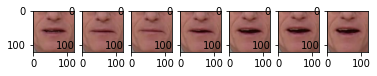

POWER/POWER_00001/


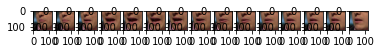

ABOUT/ABOUT_00001/


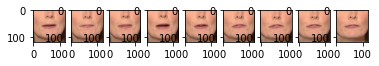

POWER/POWER_00001/


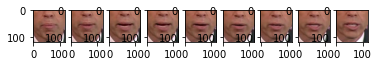

ABOUT/ABOUT_00001/


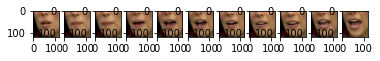

POWER/POWER_00001/


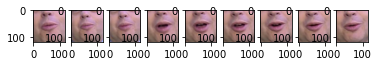

In [16]:
# read all files
images = glob.glob(f"{LRW_SAVE_DIR}/**/*.jpg", recursive=True)

# sort files according to videos
img_dict = {}
for i, img_path in enumerate(images):
  key = img_path.rsplit('_',2)[0]
  if key not in img_dict.keys():
    img_dict[key] = []
  img_dict[key].append(img_path)

# show image frames per videos
for (key, paths) in img_dict.items():
  print(os.path.join(key.rsplit('/',3)[1], key.rsplit('/',3)[2], key.rsplit('/',3)[3]))
  ncols = len(paths)
  for col_idx, p in enumerate(paths):
    sp = plt.subplot(1, ncols, col_idx + 1)
    img = mpimg.imread(p)
    plt.imshow(img)
  plt.show()